In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import seaborn as sns
import math

##### Video Inference Strong Scaling Bar Plot


In [2]:
csv_list = []
resources = [1, 2, 4, 8]

time_taken = []
tput = []

for i in resources:
    csv_list.append(
        pd.read_csv(
            f"_ALL [{i}x] g5.xlarge + [{i}x] m7i.2xlarge/video_inference_s3_g5_xlarge_batch_32.csv"
        )
    )

for csv_file in csv_list:
    time_taken.append(csv_file.iloc[-1]["time_from_start"])
    tput.append(csv_file.iloc[-1]["number_of_rows_finished"] / csv_file.iloc[-1]["time_from_start"])

In [3]:
for csv_file in csv_list:
    print(csv_file.iloc[-1]["number_of_rows_finished"] / csv_file.iloc[-1]["time_from_start"])

21.35269331385775
45.784299676621806
91.33286087414686
183.3198477792353


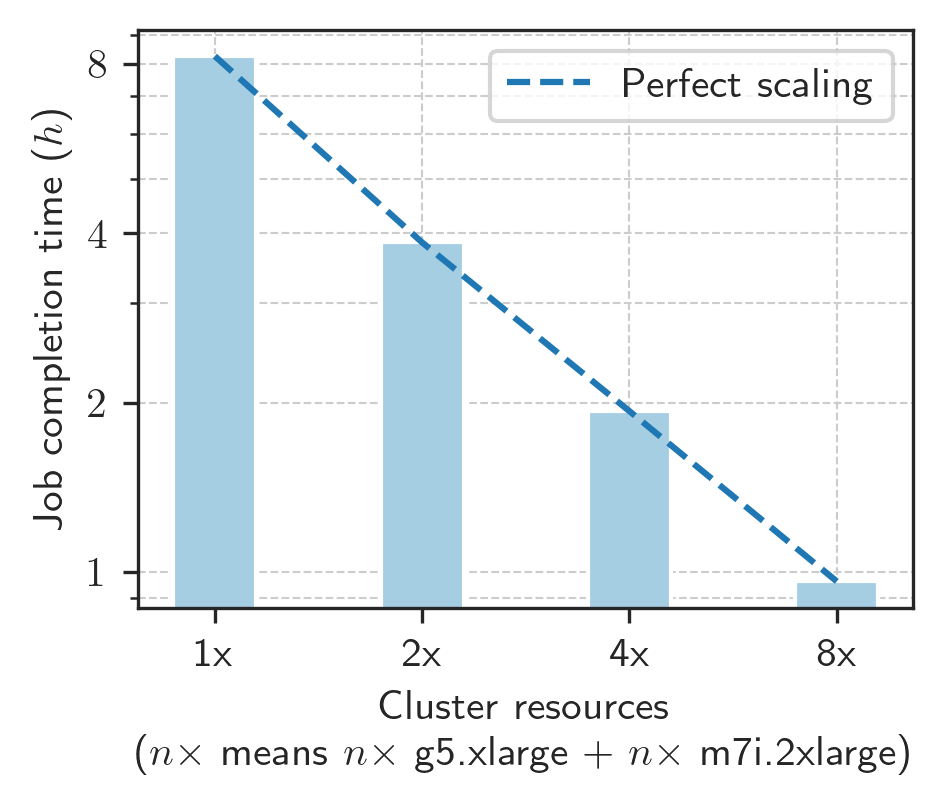

In [34]:
FIGRATIO = 3 / 4
FIGWIDTH = 3.335  # inches
FIGHEIGHT = FIGWIDTH * FIGRATIO
FIGSIZE = (FIGWIDTH, FIGHEIGHT)
BIG_SIZE = 10

resources_idx = np.arange(len(resources))
time_taken_hours = [t / 3600 for t in time_taken]

COLORS = sns.color_palette("Paired")
sns.set_style("ticks")
sns.set_palette(COLORS)

plt.rcParams.update(
    {
        "figure.figsize": FIGSIZE,
        "figure.dpi": 300,
        "text.usetex": True,
    }
)
plt.rc("font", size=BIG_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIG_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=BIG_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=BIG_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=BIG_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=BIG_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIG_SIZE)  # fontsize of the figure title

fig, ax = plt.subplots()

bars = ax.bar(resources_idx, time_taken_hours, color=COLORS[0], width=0.4)

ax.plot(resources_idx, time_taken_hours, linestyle="--", color=COLORS[1], label="Perfect scaling")

ax.set_xlabel("Cluster resources\n($n\\times$ means $n\\times$ g5.xlarge + $n\\times$ m7i.2xlarge)")
ax.set_ylabel("Job completion time ($h$)")

ax.set_yscale("log")
y_ticks = [
    2**i
    for i in range(
        int(math.log(min(time_taken_hours), 2)), int(math.log(max(time_taken_hours), 2)) + 1
    )
]
ax.set_yticks(y_ticks)
ax.set_yticklabels([f"${int(y)}$" for y in y_ticks])
ax.set_xticks(resources_idx, [f"{x}x" for x in resources])

ax.grid(True, which="both", linestyle="--", linewidth=0.5)

ax.legend()
plt.savefig("video-scaling.pdf", bbox_inches='tight')

In [ ]:
# Adjusting the plot to place each bar side by side with equal distance on the x-axis
resources_idx = np.arange(len(resources))  # Use zero-based index for positioning bars

# Create a bar plot with a line to approximate the decrease
plt.figure(figsize=(8, 6))
plt.bar(resources_idx, time_taken, color="blue", label="Time Taken", width=0.4)

# Line plot for the decreasing trend
plt.plot(resources_idx, time_taken, marker="o", color="red", label="Trend")

plt.xlabel("Index of {GPU+CPU} pairs")
plt.ylabel("Time Taken to Process All Data (seconds)")
plt.title("Strong Scaling: Time Reduction with Increased Compute Resources")
plt.xticks(resources_idx, labels=resources)  # Label x-ticks with the number of resources
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.show()

##### Single Node Tput Line Plot


In [7]:
BATCH_SIZE = 32
INSTANCE_TYPE = "g5_xlarge"
# data_local = pd.read_csv(f'video_inference_local_{INSTANCE_TYPE}_batch_{BATCH_SIZE}.csv')
data_s3_0_1 = pd.read_csv("[1x] g5.xlarge/video_inference_s3_g5_xlarge_batch_32.csv")
data_s3_1_1 = pd.read_csv("[1x] g5.xlarge + [1x] m7i.2xlarge/video_inference_s3_g5_xlarge_batch_32.csv")

In [8]:
data_s3_0_1.head()

,time_from_start,number_of_rows_finished
0,0.000000,0
1,27.537039,26
2,30.757921,52
3,34.483166,78
4,37.111850,104


In [27]:
def process(data, resample="60s"):
    data = data.copy()
    data["time_from_start"] = pd.to_timedelta(data["time_from_start"], unit="s")
    data.set_index("time_from_start", inplace=True)
    data["tput"] = data["number_of_rows_finished"].diff() / data.index.total_seconds().diff()
    data["tput"] = data["tput"].fillna(0)
    avg_tput = np.mean(data["tput"])
    # tput_resampled = data['tput'].resample(resample).bfill()
    tput_resampled = data["tput"].resample(resample).mean().bfill()
    idx = [(item.total_seconds() // 60) for item in tput_resampled.index]
    return idx, tput_resampled.values, avg_tput

In [28]:
# idx_local, values_local, avg_local = process(data_local)
# idx_s3, values_s3, avg_s3 = process(data_s3)
idx_s3_0_1, values_s3_0_1, _ = process(data_s3_0_1)
idx_s3_1_1, values_s3_1_1, _ = process(data_s3_1_1)

avg_s3_0_1 = (
    data_s3_0_1.iloc[-1]["number_of_rows_finished"] / data_s3_0_1.iloc[-1]["time_from_start"]
)
avg_s3_1_1 = (
    data_s3_1_1.iloc[-1]["number_of_rows_finished"] / data_s3_1_1.iloc[-1]["time_from_start"]
)
avg_s3_0_1, avg_s3_1_1

(6.188258389698372, 21.715949558226573)

In [29]:
tput = []
with open("inference_tput.out", "r") as f:
    for line in f:
        tput.append(float(line))
inference_tput_mean = np.mean(tput)
inference_tput_mean

23.044661492259507

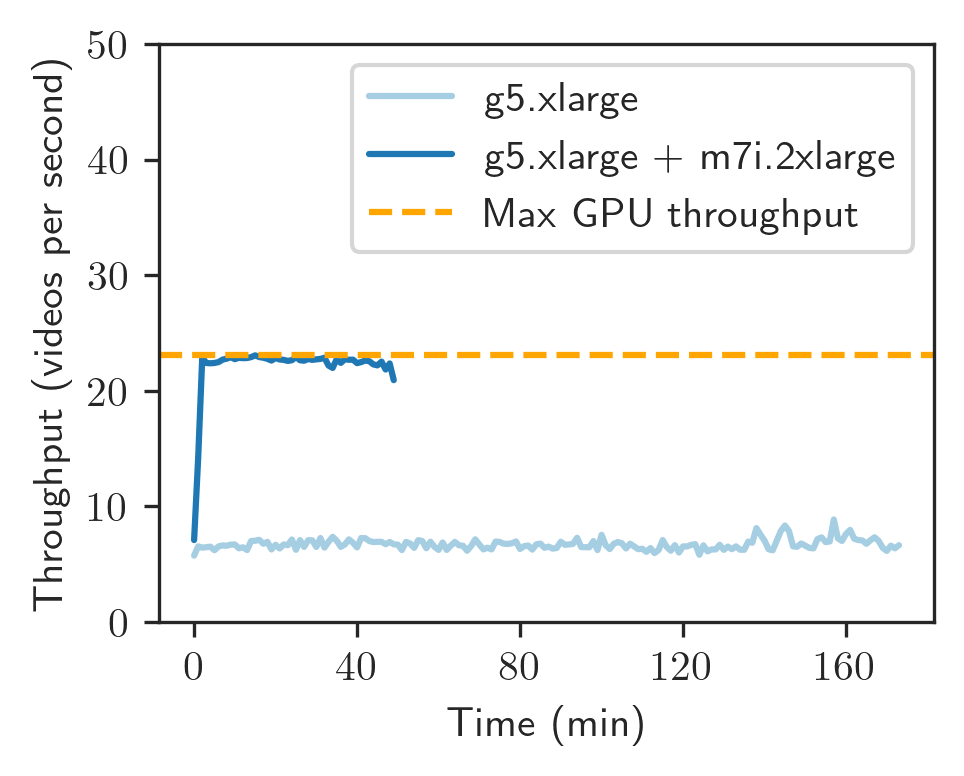

In [33]:
FIGRATIO = 3 / 4
FIGWIDTH = 3.335  # inches
FIGHEIGHT = FIGWIDTH * FIGRATIO
FIGSIZE = (FIGWIDTH, FIGHEIGHT)
BIG_SIZE = 10

COLORS = sns.color_palette("Paired")
sns.set_style("ticks")
sns.set_palette(COLORS)

plt.rcParams.update(
    {
        "figure.figsize": FIGSIZE,
        "figure.dpi": 300,
        "text.usetex": True,
    }
)
plt.rc("font", size=BIG_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIG_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=BIG_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=BIG_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=BIG_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=BIG_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIG_SIZE)  # fontsize of the figure title

fig, ax = plt.subplots()

ax.plot(idx_s3_0_1, values_s3_0_1, label="g5.xlarge")
ax.plot(idx_s3_1_1, values_s3_1_1, label="g5.xlarge + m7i.2xlarge")

ax.axhline(
    y=inference_tput_mean, color="orange", linestyle="--", label="Max GPU throughput"
)

plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

plt.xlabel("Time (min)")
plt.ylabel("Throughput (videos per second)")
plt.ylim(0, 50)
plt.legend()
plt.savefig("video-tput.pdf", bbox_inches='tight')

In [15]:
idx_s3_0_1

['0:00:00',
 '0:01:00',
 '0:02:00',
 '0:03:00',
 '0:04:00',
 '0:05:00',
 '0:06:00',
 '0:07:00',
 '0:08:00',
 '0:09:00',
 '0:10:00',
 '0:11:00',
 '0:12:00',
 '0:13:00',
 '0:14:00',
 '0:15:00',
 '0:16:00',
 '0:17:00',
 '0:18:00',
 '0:19:00',
 '0:20:00',
 '0:21:00',
 '0:22:00',
 '0:23:00',
 '0:24:00',
 '0:25:00',
 '0:26:00',
 '0:27:00',
 '0:28:00',
 '0:29:00',
 '0:30:00',
 '0:31:00',
 '0:32:00',
 '0:33:00',
 '0:34:00',
 '0:35:00',
 '0:36:00',
 '0:37:00',
 '0:38:00',
 '0:39:00',
 '0:40:00',
 '0:41:00',
 '0:42:00',
 '0:43:00',
 '0:44:00',
 '0:45:00',
 '0:46:00',
 '0:47:00',
 '0:48:00',
 '0:49:00',
 '0:50:00',
 '0:51:00',
 '0:52:00',
 '0:53:00',
 '0:54:00',
 '0:55:00',
 '0:56:00',
 '0:57:00',
 '0:58:00',
 '0:59:00',
 '1:00:00',
 '1:01:00',
 '1:02:00',
 '1:03:00',
 '1:04:00',
 '1:05:00',
 '1:06:00',
 '1:07:00',
 '1:08:00',
 '1:09:00',
 '1:10:00',
 '1:11:00',
 '1:12:00',
 '1:13:00',
 '1:14:00',
 '1:15:00',
 '1:16:00',
 '1:17:00',
 '1:18:00',
 '1:19:00',
 '1:20:00',
 '1:21:00',
 '1:22:00',
 '1:

##### Fault Tolerance


In [4]:
data_s3_1_1 = pd.read_csv("_FAULT [1x] g5.xlarge + [1x] m7i.2xlarge/video_inference_s3_g5_xlarge_batch_32.csv")

In [5]:
def process(data, resample="60s"):
    data = data.copy()
    data["time_from_start"] = pd.to_timedelta(data["time_from_start"], unit="s")
    data.set_index("time_from_start", inplace=True)
    data["tput"] = data["number_of_rows_finished"].diff() / data.index.total_seconds().diff()
    data["tput"] = data["tput"].fillna(0)
    avg_tput = np.mean(data["tput"])
    # tput_resampled = data['tput'].resample(resample).bfill()
    tput_resampled = data["tput"].resample(resample).mean().bfill()
    idx = [(item.total_seconds() // 60) for item in tput_resampled.index]
    return idx, tput_resampled.values, avg_tput

In [7]:
idx_s3_1_1, values_s3_1_1, _ = process(data_s3_1_1)

avg_s3_1_1 = (
    data_s3_1_1.iloc[-1]["number_of_rows_finished"] / data_s3_1_1.iloc[-1]["time_from_start"]
)
avg_s3_1_1

18.62964358322438

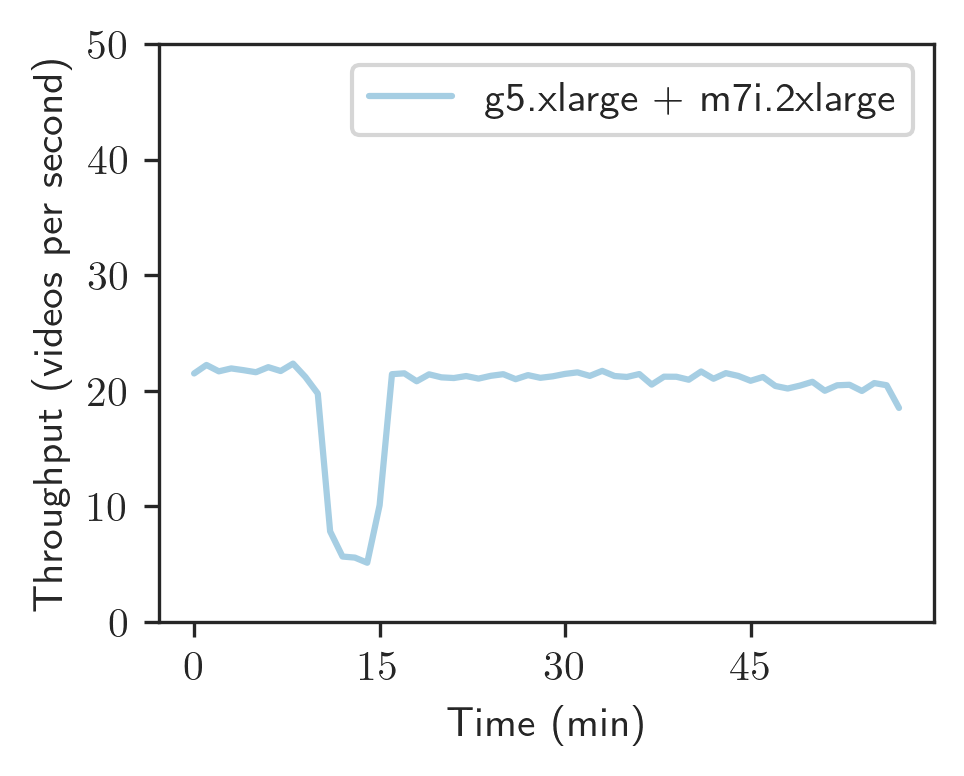

In [9]:
FIGRATIO = 3 / 4
FIGWIDTH = 3.335  # inches
FIGHEIGHT = FIGWIDTH * FIGRATIO
FIGSIZE = (FIGWIDTH, FIGHEIGHT)
BIG_SIZE = 10

COLORS = sns.color_palette("Paired")
sns.set_style("ticks")
sns.set_palette(COLORS)

plt.rcParams.update(
    {
        "figure.figsize": FIGSIZE,
        "figure.dpi": 300,
        "text.usetex": True,
    }
)
plt.rc("font", size=BIG_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIG_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=BIG_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=BIG_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=BIG_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=BIG_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIG_SIZE)  # fontsize of the figure title

fig, ax = plt.subplots()

ax.plot(idx_s3_1_1, values_s3_1_1, label="g5.xlarge + m7i.2xlarge")

# ax.axhline(
#     y=inference_tput_mean, color="orange", linestyle="--", label="Max GPU throughput"
# )

plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

plt.xlabel("Time (min)")
plt.ylabel("Throughput (videos per second)")
plt.ylim(0, 50)
plt.legend()
plt.savefig("video-tput.pdf", bbox_inches='tight')

Scaffolding

In [20]:
data = data_local

In [21]:
data["time_from_start"] = pd.to_timedelta(data["time_from_start"], unit="s")
data.set_index("time_from_start", inplace=True)
data.head()

,number_of_rows_finished
time_from_start,
0 days 00:00:00,0
0 days 00:00:24.065711737,64
0 days 00:00:26.937317610,128
0 days 00:00:34.137617826,192
0 days 00:00:38.946805239,256


In [23]:
data["tput"] = data["number_of_rows_finished"].diff() / data.index.total_seconds().diff()
data["tput"] = data["tput"].fillna(0)
data["tput"]

time_from_start
0 days 00:00:00               0.000000
0 days 00:00:24.065711737     2.659385
0 days 00:00:26.937317610    22.287181
0 days 00:00:34.137617826     8.888518
0 days 00:00:38.946805239    13.307861
                               ...    
0 days 01:10:02.566852808    20.694870
0 days 01:10:08.862399578    10.165916
0 days 01:10:11.564971209    23.681148
0 days 01:10:14.180271149    24.471381
0 days 01:10:14.871382952    24.598046
Name: tput, Length: 840, dtype: float64

In [25]:
tput_resampled = data["tput"].resample("5s").mean().ffill()
tput_resampled

time_from_start
0 days 00:00:00     0.000000
0 days 00:00:05     0.000000
0 days 00:00:10     0.000000
0 days 00:00:15     0.000000
0 days 00:00:20     2.659385
                     ...    
0 days 01:09:50    15.294489
0 days 01:09:55    11.733092
0 days 01:10:00    20.694870
0 days 01:10:05    10.165916
0 days 01:10:10    24.250192
Freq: 5s, Name: tput, Length: 843, dtype: float64